In [1]:
import pathlib
import os
from glob import glob

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import cloudpickle

import sklearn
from sklearn.linear_model import LinearRegression as LinReg


import SessionTools.two_photon as st2p
# from SessionTools.two_photon import utilities
from SessionTools.utilities import *


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['pdf.use14corefonts']=True
# matplotlib.rc('font', family='arial')



%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [15]:
date = "11_08_2023"
genotype = "R60D05_LexOpjRGECO1a_R4d_sytjGCaMP7f"
fly = "fly2"
session = 'baseline-000'
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{genotype}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{genotype}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=1)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)
    
figdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/fig_scratch/EL_meeting/antibump/{date}/{genotype}/{fly}/{session}/')
os.makedirs(figdir, exist_ok=True)

In [16]:
f = h5py.File(h5name)
data = f['/data'][:]

ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[1,:,:,:], in_place=False)

napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{genotype}/{fly}/{session}/napari.pkl'


with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks_EB = np_layers['rois_EB']
masks_R4d = np_layers['rois_R4d']
background = np_layers['background']

In [17]:
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{genotype}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [18]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [19]:
if background.ravel().sum()>0:
    F_EB, notF_EB = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks_EB, 16, bckgnd_mask = background, max_proj=False) 
    F_R4d, notF_R4d = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks_R4d, 16, bckgnd_mask = background, max_proj=False) 
else:
    F_EB, notF_EB = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks_EB, 16, bckgnd_mask = None, max_proj=False) 
    F_R4d, notF_R4d = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks_R4d, 16, bckgnd_mask = None, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [20]:
# remove background
for ch in range(F_EB.shape[0]):
    lr = LinReg().fit(notF_EB[ch,np.newaxis, :].T, F_EB[ch,:,:].T)
    F_EB[ch,:,:] = F_EB[ch,:,:]-1.*lr.predict(notF_EB[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]


for ch in range(F_R4d.shape[0]):
    lr = LinReg().fit(notF_R4d[ch,np.newaxis, :].T, F_R4d[ch,:,:].T)
    F_R4d[ch,:,:] = F_R4d[ch,:,:]-1.*lr.predict(notF_R4d[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]




# remove bleedthrough
coef = 1.
if True:
    
    
    lr = LinReg().fit(F_EB[1,:,:].mean(axis=0,keepdims=True).T, F_EB[0,:,:].mean(axis=0,keepdims=True).T)
    F_EB[0,:,:] = np.maximum(F_EB[0,:,:] - coef*lr.coef_*F_EB[1,:,:], 0) + lr.intercept_
    print(lr.coef_)
    

    
    lr = LinReg().fit(F_R4d[0,:,:].mean(axis=0,keepdims=True).T, F_R4d[1,:,:].mean(axis=0,keepdims=True).T)
    F_R4d[1,:,:] = np.maximum(F_R4d[1,:,:] - coef*lr.coef_*F_R4d[0,:,:], 0) + lr.intercept_
    print(lr.coef_)
    
    

F_EB = sp.ndimage.gaussian_filter1d(F_EB,2,axis=-1)
F_EB = sp.ndimage.gaussian_filter1d(F_EB,1.5,axis=1, mode='wrap')


F_R4d = sp.ndimage.gaussian_filter1d(F_R4d,2,axis=-1)
F_R4d = sp.ndimage.gaussian_filter1d(F_R4d,1.5,axis=1, mode='wrap')

[[0.20479745]]
[[0.11101033]]


In [21]:
dff_R4d = sp.stats.zscore(F_R4d[1,:,:]/np.linalg.norm(F_R4d[1,:,:], axis=0, keepdims=True), axis=-1)
dff_EB = sp.stats.zscore(F_EB[0,:,:]/np.linalg.norm(F_EB[0,:,:], axis=0, keepdims=True), axis=-1)
# dff_EB = sp.stats.zscore(F_EB[0,:,:], axis=-1)

In [22]:
x_f_r4d,y_f_r4d = st2p.utilities.pol2cart(dff_R4d,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
pv_len_r4d,pv_ang_r4d = st2p.utilities.cart2pol(x_f_r4d.mean(axis=0), y_f_r4d.mean(axis=0))


x_f_eb,y_f_eb = st2p.utilities.pol2cart(dff_EB,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
pv_len_eb,pv_ang_eb = st2p.utilities.cart2pol(x_f_eb.mean(axis=0), y_f_eb.mean(axis=0))


_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))



_,offset_r4d = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),pv_ang_r4d-heading))


_,offset_eb = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),pv_ang_eb-heading))


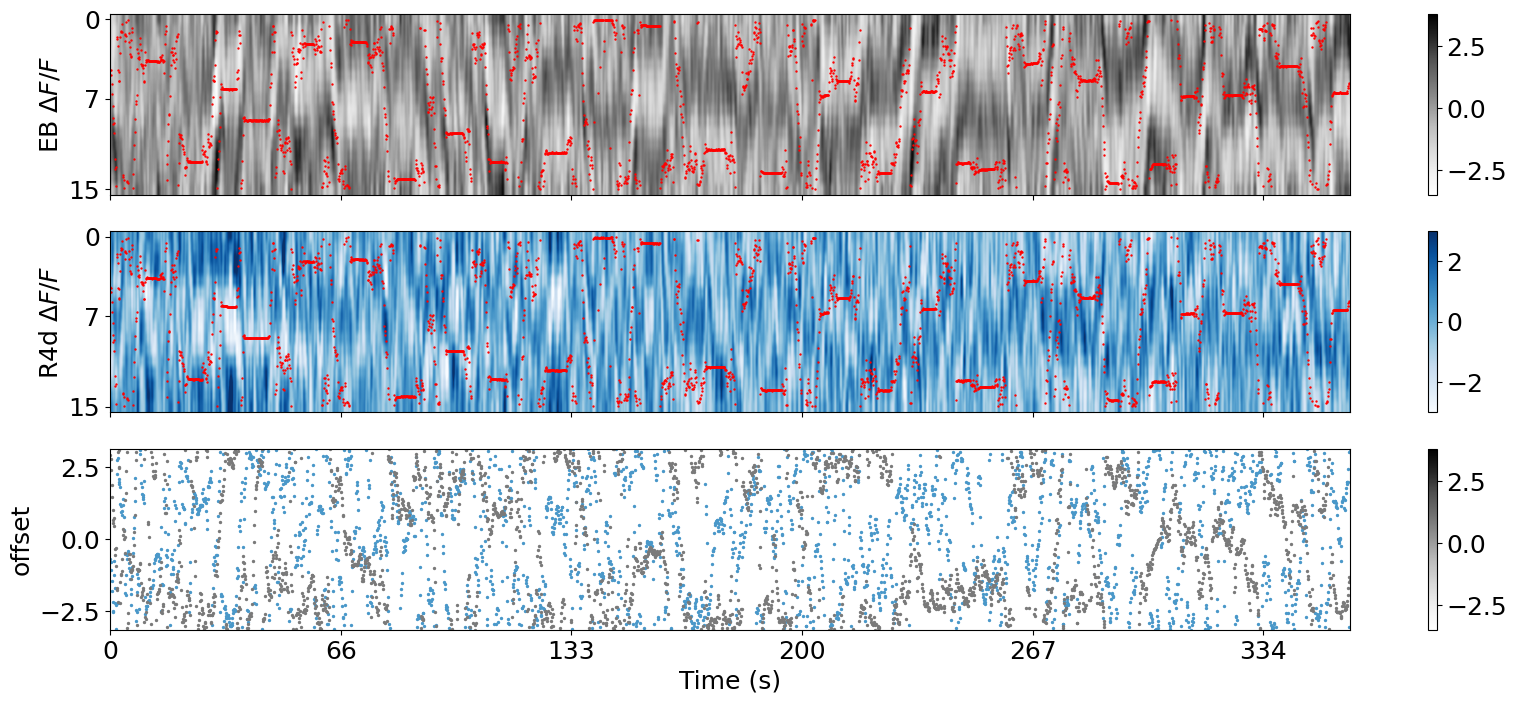

In [23]:

plt.rcParams.update({'font.size':18})

start, stop = 0, dff_R4d.shape[-1]

window = slice(start, stop)
x = np.arange(stop-start)
time = df_aligned['Time(ms)'].to_numpy()
time = time-time[0]
    
fig, ax = plt.subplots(3,1,figsize=[20,8], sharex=True)
dff_window = dff_R4d[:,window]
h = ax[1].imshow(dff_window,aspect='auto',cmap='Blues',vmin=-3,vmax=3)
plt.colorbar(h, ax=ax[1])
ax[1].set_yticks([0,7,15])
ax[1].set_ylabel(r"R4d $  \Delta F/F$")


ax[1].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)


dff_r_window = dff_EB[:,window]
h = ax[0].imshow(dff_r_window,aspect='auto',cmap='Greys')#,vmin=-2,vmax=2)
plt.colorbar(h, ax=ax[0])
ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)
ax[0].set_yticks([0,7,15])
ax[0].set_ylabel(r"EB $\Delta F/F$")


plt.colorbar(h, ax=ax[2])
ax[2].scatter(x,offset_r4d[window],s=2, color=plt.cm.Blues(.6))
ax[2].scatter(x,offset_eb[window],s=2, color=plt.cm.Greys(.6))
ax[2].set_ylim([-3.14,3.14])
# # ax[1].plot(x,0*offset[window], marker='_')


ax[2].set_ylabel('offset')
ax[2].set_xlabel('Time (s)')

ax[2].set_xticks(x[::500], labels = [str(int(time[i]/1000)) for i in range(0,x[-1]+1,500)])

fig.savefig(figdir.joinpath('dff_w_offset.pdf'))



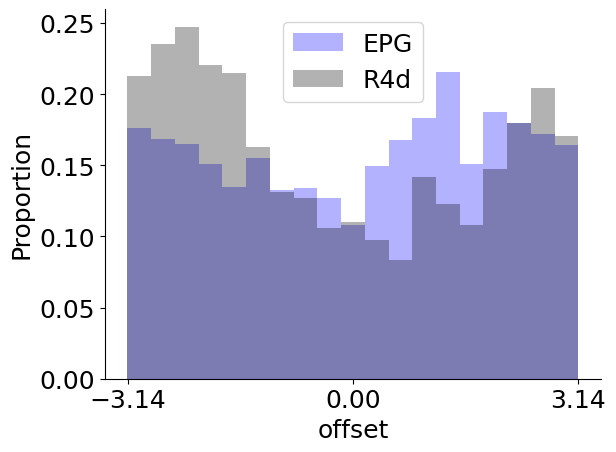

In [24]:
fig,ax = plt.subplots()
bin_edges=np.linspace(-np.pi,np.pi,num=20)


ax.hist(offset_r4d,bins = bin_edges, alpha=.3, color='blue',density=True, label='EPG')
ax.hist(offset_eb,bins = bin_edges, alpha=.3, color='black',density=True, label='R4d')

ax.legend()
ax.set_xlabel('offset')
ax.set_ylabel('Proportion')
ax.set_xticks([-3.14, 0, 3.14])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(figdir.joinpath('offset_hist.pdf'))


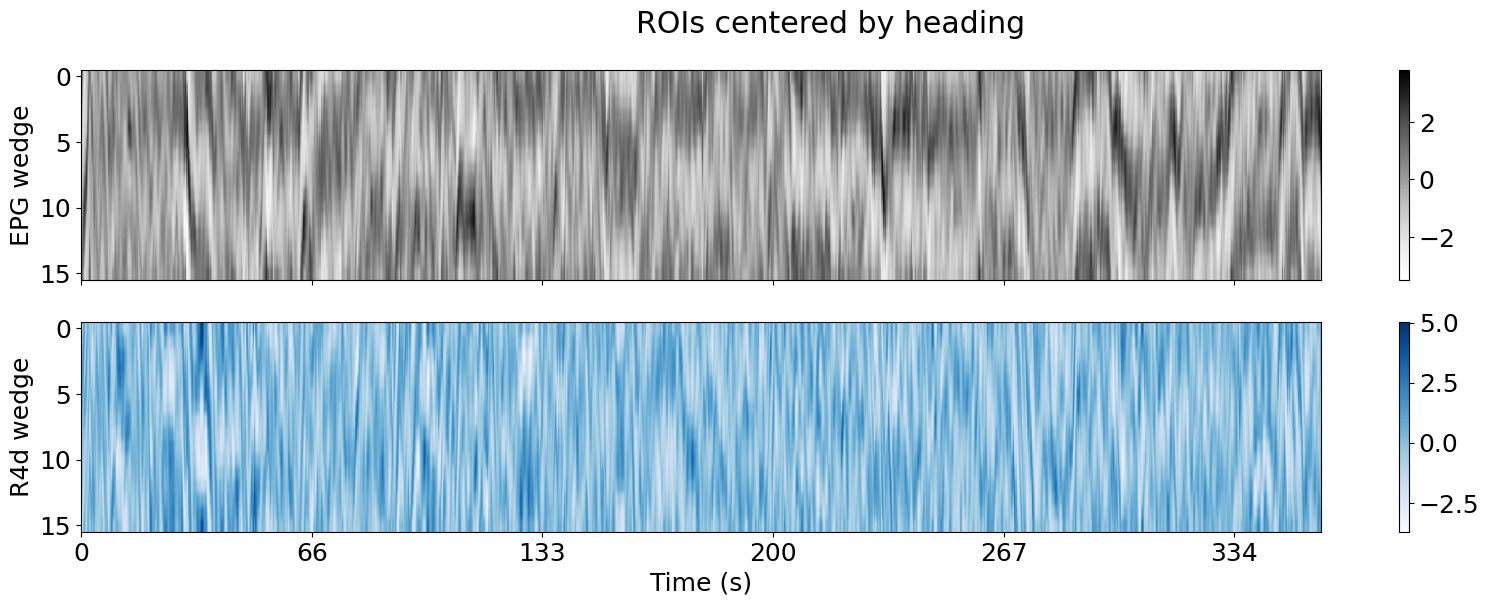

In [32]:
max_inds = (15*(heading+np.pi)/2/np.pi).astype(int)
dff_EB_maxal = 0*dff_EB
dff_R4d_maxal = 0*dff_EB
for t in range(dff_EB.shape[1]):
    dff_EB_maxal[:,t] = np.roll(dff_EB[:,t], -max_inds[t]-8)
    dff_R4d_maxal[:,t] = np.roll(dff_R4d[:,t], -max_inds[t]-8)


fig, ax = plt.subplots(2,1, figsize=[20,6], sharex=True)

h = ax[0].imshow(dff_EB_maxal[:,start:stop],aspect='auto',cmap='Greys', interpolation=None) #,vmin=-3,vmax=3)
plt.colorbar(h, ax = ax[0])
h = ax[1].imshow(dff_R4d_maxal[:,start:stop],aspect='auto',cmap='Blues', interpolation=None) #,vmin=-3,vmax=3)
plt.colorbar(h, ax=ax[1])


ax[1].set_xticks(x[::500], labels = [str(int(time[i]/1000)) for i in range(0,x[-1]+1,500)])


ax[0].set_ylabel('EPG wedge')
ax[1].set_ylabel('R4d wedge')
ax[1].set_xlabel('Time (s)')
fig.suptitle('ROIs centered by heading')
fig.savefig(figdir.joinpath('heading_centered_dff.pdf'))



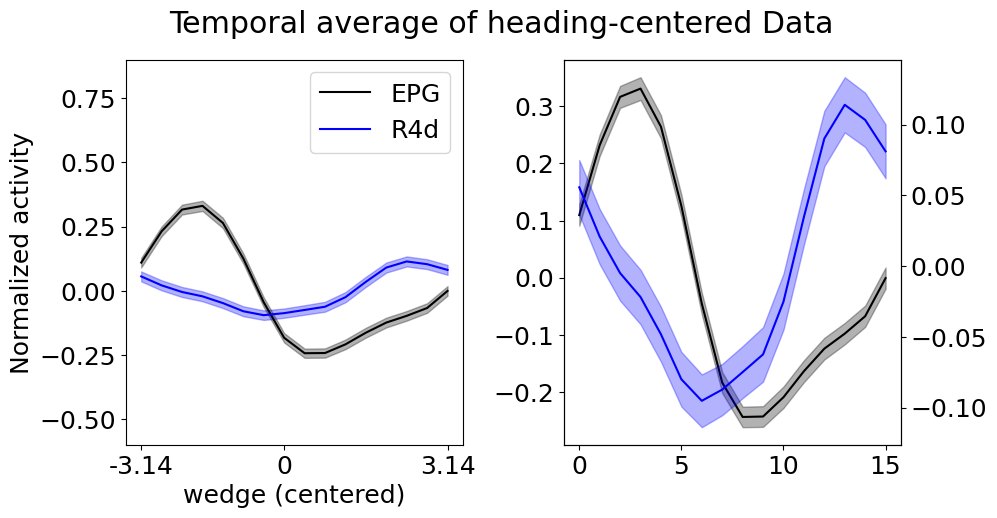

In [35]:
fig, ax = plt.subplots(1,2, figsize=[10, 5])
fig.subplots_adjust(wspace=.3)

mu, sem = dff_EB_maxal[:,start:stop].mean(axis=-1), sp.stats.sem(dff_EB_maxal[:, start:stop], axis=-1)

ax[0].plot(mu, color='black', label='EPG')
ax[0].fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='black')
ax[1].plot(mu, color='black')
ax[1].fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='black')


mu, sem = dff_R4d_maxal[:,start:stop].mean(axis=-1), sp.stats.sem(dff_R4d_maxal[:, start:stop], axis=-1)

ax[0].plot(mu, color='blue', label='R4d')
ax[0].fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='blue')

ax[0].set_xlabel('wedge (centered)')
ax[0].set_ylabel('Normalized activity')
ax[0].set_ylim([-.6,.9])
ax[0].set_xticks([0,7,15],labels=[-3.14, 0, 3.14])

ax[0].legend()

ax2 = ax[1].twinx()
ax2.plot(mu, color='blue')
ax2.fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='blue')


fig.suptitle('Temporal average of heading-centered Data')

fig.savefig(figdir.joinpath('avg_centered_dff.pdf'))


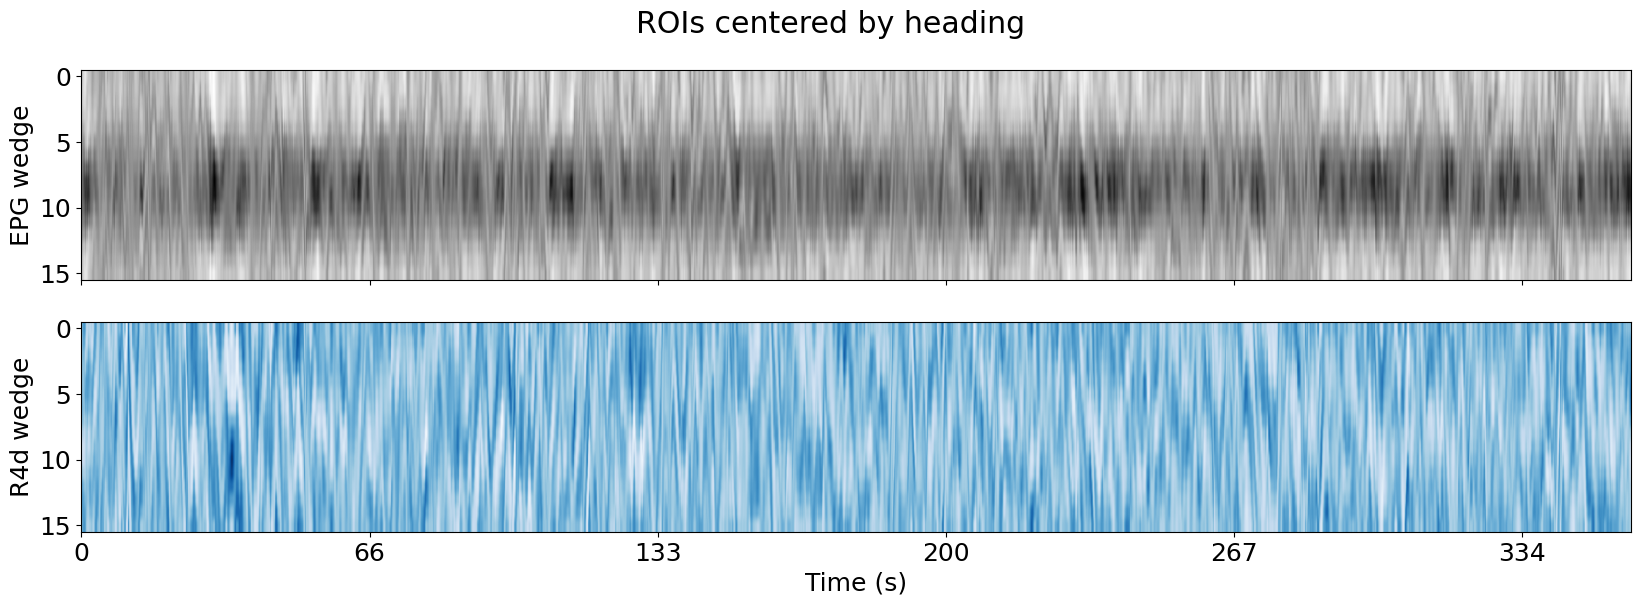

In [27]:
max_inds = (15*(pv_ang_eb+np.pi)/2/np.pi).astype(int)
dff_EB_maxal = 0*dff_EB
dff_R4d_maxal = 0*dff_EB
for t in range(dff_EB.shape[1]):
    dff_EB_maxal[:,t] = np.roll(dff_EB[:,t], -max_inds[t]-8)
    dff_R4d_maxal[:,t] = np.roll(dff_R4d[:,t], -max_inds[t]-8)


fig, ax = plt.subplots(2,1, figsize=[20,6], sharex=True)

ax[0].imshow(dff_EB_maxal[:,start:stop],aspect='auto',cmap='Greys', interpolation=None) #,vmin=-3,vmax=3)
ax[1].imshow(dff_R4d_maxal[:,start:stop],aspect='auto',cmap='Blues', interpolation=None) #,vmin=-3,vmax=3)


ax[1].set_xticks(x[::500], labels = [str(int(time[i]/1000)) for i in range(0,x[-1]+1,500)])

ax[0].set_ylabel('EPG wedge')
ax[1].set_ylabel('R4d wedge')
ax[1].set_xlabel('Time (s)')
fig.suptitle('ROIs centered by heading')
fig.savefig(figdir.joinpath('EB_centered_dff.pdf'))



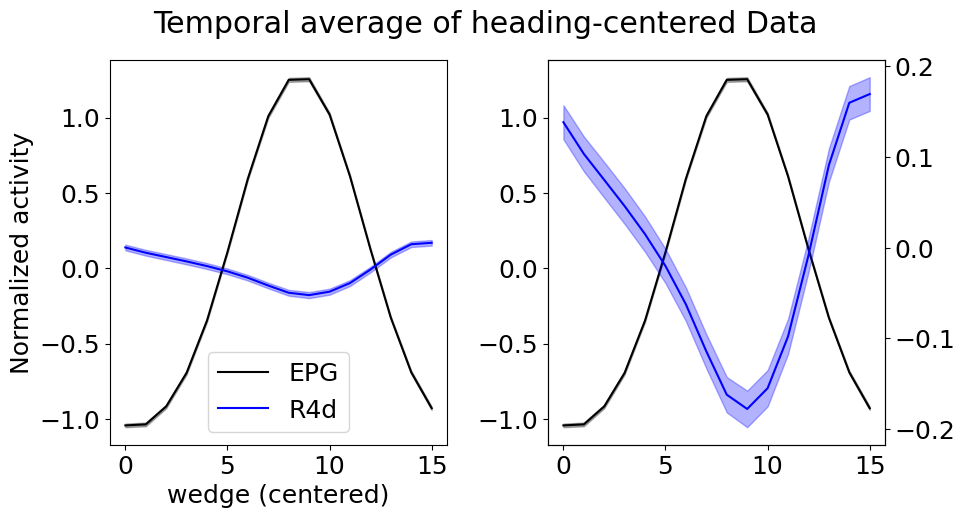

In [28]:
fig, ax = plt.subplots(1,2, figsize=[10, 5])
fig.subplots_adjust(wspace=.3)

mu, sem = dff_EB_maxal[:,start:stop].mean(axis=-1), sp.stats.sem(dff_EB_maxal[:, start:stop], axis=-1)

ax[0].plot(mu, color='black', label='EPG')
ax[0].fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='black')
ax[1].plot(mu, color='black')
ax[1].fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='black')


mu, sem = dff_R4d_maxal[:,start:stop].mean(axis=-1), sp.stats.sem(dff_R4d_maxal[:, start:stop], axis=-1)

ax[0].plot(mu, color='blue', label='R4d')
ax[0].fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='blue')

ax[0].set_xlabel('wedge (centered)')
ax[0].set_ylabel('Normalized activity')

ax[0].legend()

ax2 = ax[1].twinx()
ax2.plot(mu, color='blue')
ax2.fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='blue')


fig.suptitle('Temporal average of heading-centered Data')

fig.savefig(figdir.joinpath('avg_eb_centered_dff.pdf'))
